# Meir, go NUTS:

In [1]:
import numpyro

# Set the number of cores on your machine for parallel computing:
cpu_cores = 8
numpyro.set_host_device_count(cpu_cores)

import numpy as np
import matplotlib.pyplot as plt
from fleck.jax import ActiveStar

/Users/mschochet/anaconda3/envs/jaxofleck/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's set up the ($\lambda$, $t$) space of the observations:

In [77]:
import os
from lco_functions import file_len, file_load, create_lc
import lightkurve as lk
import pandas as pd
stella_data = pd.read_csv('../tess/stella/stella_lc.csv')
stella_lc_og = lk.LightCurve(flux=stella_data['flux'], \
                             time=stella_data['time'], \
                             flux_err=stella_data['flux_err'])

with open('../tess/stella/stella_probabilities.npy', 'rb') as f:
    avg_pred = np.load(f)

stella_lc_og.add_column(avg_pred, name='stella_prob')
stella_lc_folded = stella_lc_og.copy().fold(4.86, epoch_time=2400000, epoch_phase=3)

folded_params = [np.ascontiguousarray(param, dtype=np.float64) for param in \
                 [stella_lc_folded.time.value, stella_lc_folded.flux, \
                  stella_lc_folded.flux_err * stella_lc_folded.stella_prob, \
                  stella_lc_folded.flux_err]]

x, y, yerr_scaled, yerr = folded_params

In [78]:
times = np.linspace(np.min(x), np.max(x), len(x))

# these are placeholder numbers for the different filters.
# the values don't matter here, we're just using N 
# wavelengths to represent N filters:
wavelengths = np.array([1, 2, 3, 4, 5, 6]) # shape=(N_filters, )

# we'll define our spot contrast by setting the 
# photospheric flux to unity in each filter:
phot = np.array([1, 1, 1, 1, 1, 1]) # shape=(N_filters, )
# and by setting the spot spectrum across the three
# filters by setting the
# ratio of the spot to photospheric flux 
# (F_spot / F_star) in each filter:
spectrum = np.array([0.8, 0.7, 0.6, 0.5, 0.4, 0.3]) # shape=(N_filters, )

Create an ActiveStar object:

In [80]:
star = ActiveStar(
    times=times,
    P_rot=4.86,
    inclination=np.pi/2,
    wavelength=wavelengths,
    phot=phot, 
    # the kwarg below says 'spectrum', it means 'spot spectrum'
    spectrum=spectrum
)

Set the spot positions:

In [38]:
# now add spot locations and radii. each vector has
# shape = (N_spots, )
star.lat = np.pi * np.array([0.5])
star.lon = 2 * np.pi * np.array([0])
star.rad = np.array([0.05])

In [ ]:
np.array()

Compute and plot the rotational light curve:

In [85]:
obs_fr = np.empty((len(y), len(wavelengths), 1))
err_fr = np.empty((len(y), len(wavelengths), 1))

for i in range(len(wavelengths)):
    obs_fr[..., 0][:, i] = y
    err_fr[..., 0][:, i] = yerr

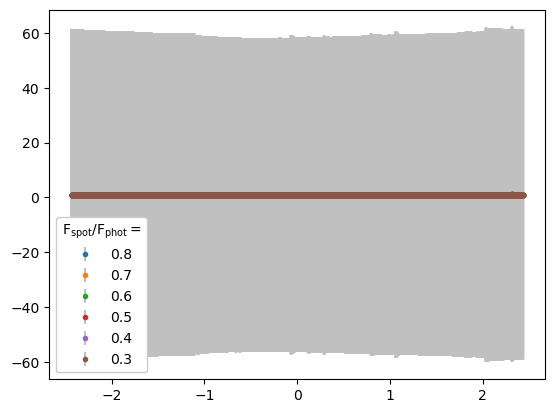

In [86]:
lc, f_S = star.rotation_model(f0=1)

# `lc` has shape (N_times, N_wavelengths, N_inclinations).
# you'll usually be fitting only one inclination, so you can 
# extract the 0th slice on that axis. see below an for example:

y_obs = lc[..., 0]
y_err = 1e-4 * np.ones_like(y_obs)

for i in range(y_obs.shape[1]):
    plt.errorbar(times, obs_fr[:, i, 0], err_fr[:, i, 0], fmt='.', ecolor='silver', label=spectrum[i])


plt.legend(title=r'${\rm F_{spot}} / {\rm F_{phot}} = $', loc='lower left', framealpha=1)

Now let's pretend those simultaneous light curves are actually observations, and let's fit them:

In [51]:
import jax
import numpyro
from numpyro import distributions as dist
from numpyro.infer import NUTS, MCMC


def lc_model(lat, lon, rad, f0, Fspot_Fphot):
    star = ActiveStar(
        times=times,
        P_rot=4.86,
        inclination=np.pi/2,
        wavelength=wavelengths,
        phot=phot, 
        spectrum=Fspot_Fphot
    )
    star.lat = lat
    star.lon = lon
    star.rad = rad
    lc, _ = star.rotation_model(f0=f0)
    return lc[..., 0]

n_spots = star.lon.size
n_wavelengths = wavelengths.size

In [52]:

def numpyro_model():
    lat = numpyro.sample(
        'lat', dist.Uniform(0, np.pi), sample_shape=(n_spots,)
    )
    lon = numpyro.sample(
        'lon', dist.Uniform(-np.pi, np.pi), sample_shape=(n_spots,)
    )
    rad = numpyro.sample(
        'rad', dist.Uniform(0.01, 0.1), sample_shape=(n_spots,)
    )
    f0 = 1
    Fspot_Fphot = numpyro.sample(
        'Fspot_Fphot', dist.Uniform(0.5, 0.8), sample_shape=(n_wavelengths,)
    )

    light_curve = lc_model(lat, lon, rad, f0, Fspot_Fphot)

    # save this light curve sample along with the chains:
    numpyro.deterministic('light_curve', light_curve)

    numpyro.sample(
        'obs',
        dist.Normal(
            loc=light_curve,
            scale=y_err,
        ),
        obs=y_obs
    )

Run the NUTS in parallel:

In [ ]:
# Random numbers in jax are generated like this:
rng_keys = jax.random.split(
    jax.random.PRNGKey(0), 
    cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=300, 
    num_samples=500, 
    num_chains=cpu_cores
)

# Run the MCMC
mcmc.run(rng_keys)

Compiling.. :   0%|          | 0/800 [00:00<?, ?it/s]









































Running chain 0:   0%|          | 0/800 [00:01<?, ?it/s]



























Running chain 0:  10%|█         | 80/800 [00:02<00:01, 602.48it/s]



















Running chain 0:  15%|█▌        | 120/800 [00:02<00:01, 396.32it/s]
















Running chain 0:  20%|██        | 160/800 [00:02<00:02, 255.75it/s]











Running chain 0:  30%|███       | 240/800 [00:02<00:01, 345.39it/s]



















Running chain 0:  40%|████      | 320/800 [00:02<00:01, 360.43it/s]






Running chain 0:  45%|████▌     | 360/800 [00:02<00:01, 357.80it/s]




Running chain 0:  55%|█████▌    | 440/800 [00:02<00:00, 450.84it/s]







Running chain 0:  65%|██████▌   | 520/800 [00:03<00:00, 503.12it/s]







Running chain 0:  75%|███████▌  | 600/800 [00:03<00:00, 521.65it/s]


















Running chain 1: 100%|██████████| 800/800 [00:03<00:00, 233.18it/s]











Running chain 0: 100%|██████████| 800/800 [00:03<00:00, 215.02it/s]





Running chain 6: 100%|██████████| 800/800 [00:03<00:00, 214.45it/s]






































Use arviz to handle the posteriors:

In [54]:
import arviz
results = arviz.from_numpyro(mcmc)

Extract the light curve models from each sample, reshape into (N_samples, N_times, N_filters):

In [55]:
light_curve_samples = results.posterior['light_curve'].to_numpy()

light_curve_samples = light_curve_samples.reshape((-1,) + light_curve_samples.shape[2:])

In [56]:
np.shape(light_curve_samples)

(4000, 150, 6)

Plot the light curve samples on the data:

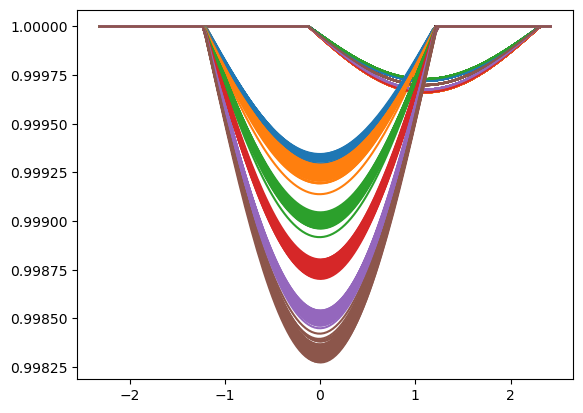

In [60]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for i in range(0, light_curve_samples.shape[0], 10):
    for j in range(wavelengths.size):
        plt.plot(times, light_curve_samples[i, :, j], color=colors[j])
        #continue
for i in range(y_obs.shape[1]):
    #plt.errorbar(
    #    times, y_obs[:, i], #y_err[:, i], 
    #    fmt='o', color='none', ecolor='gainsboro', 
    #    label=spectrum[i], mec='k', alpha=0.5
    #)
    continue

And a corner plot:

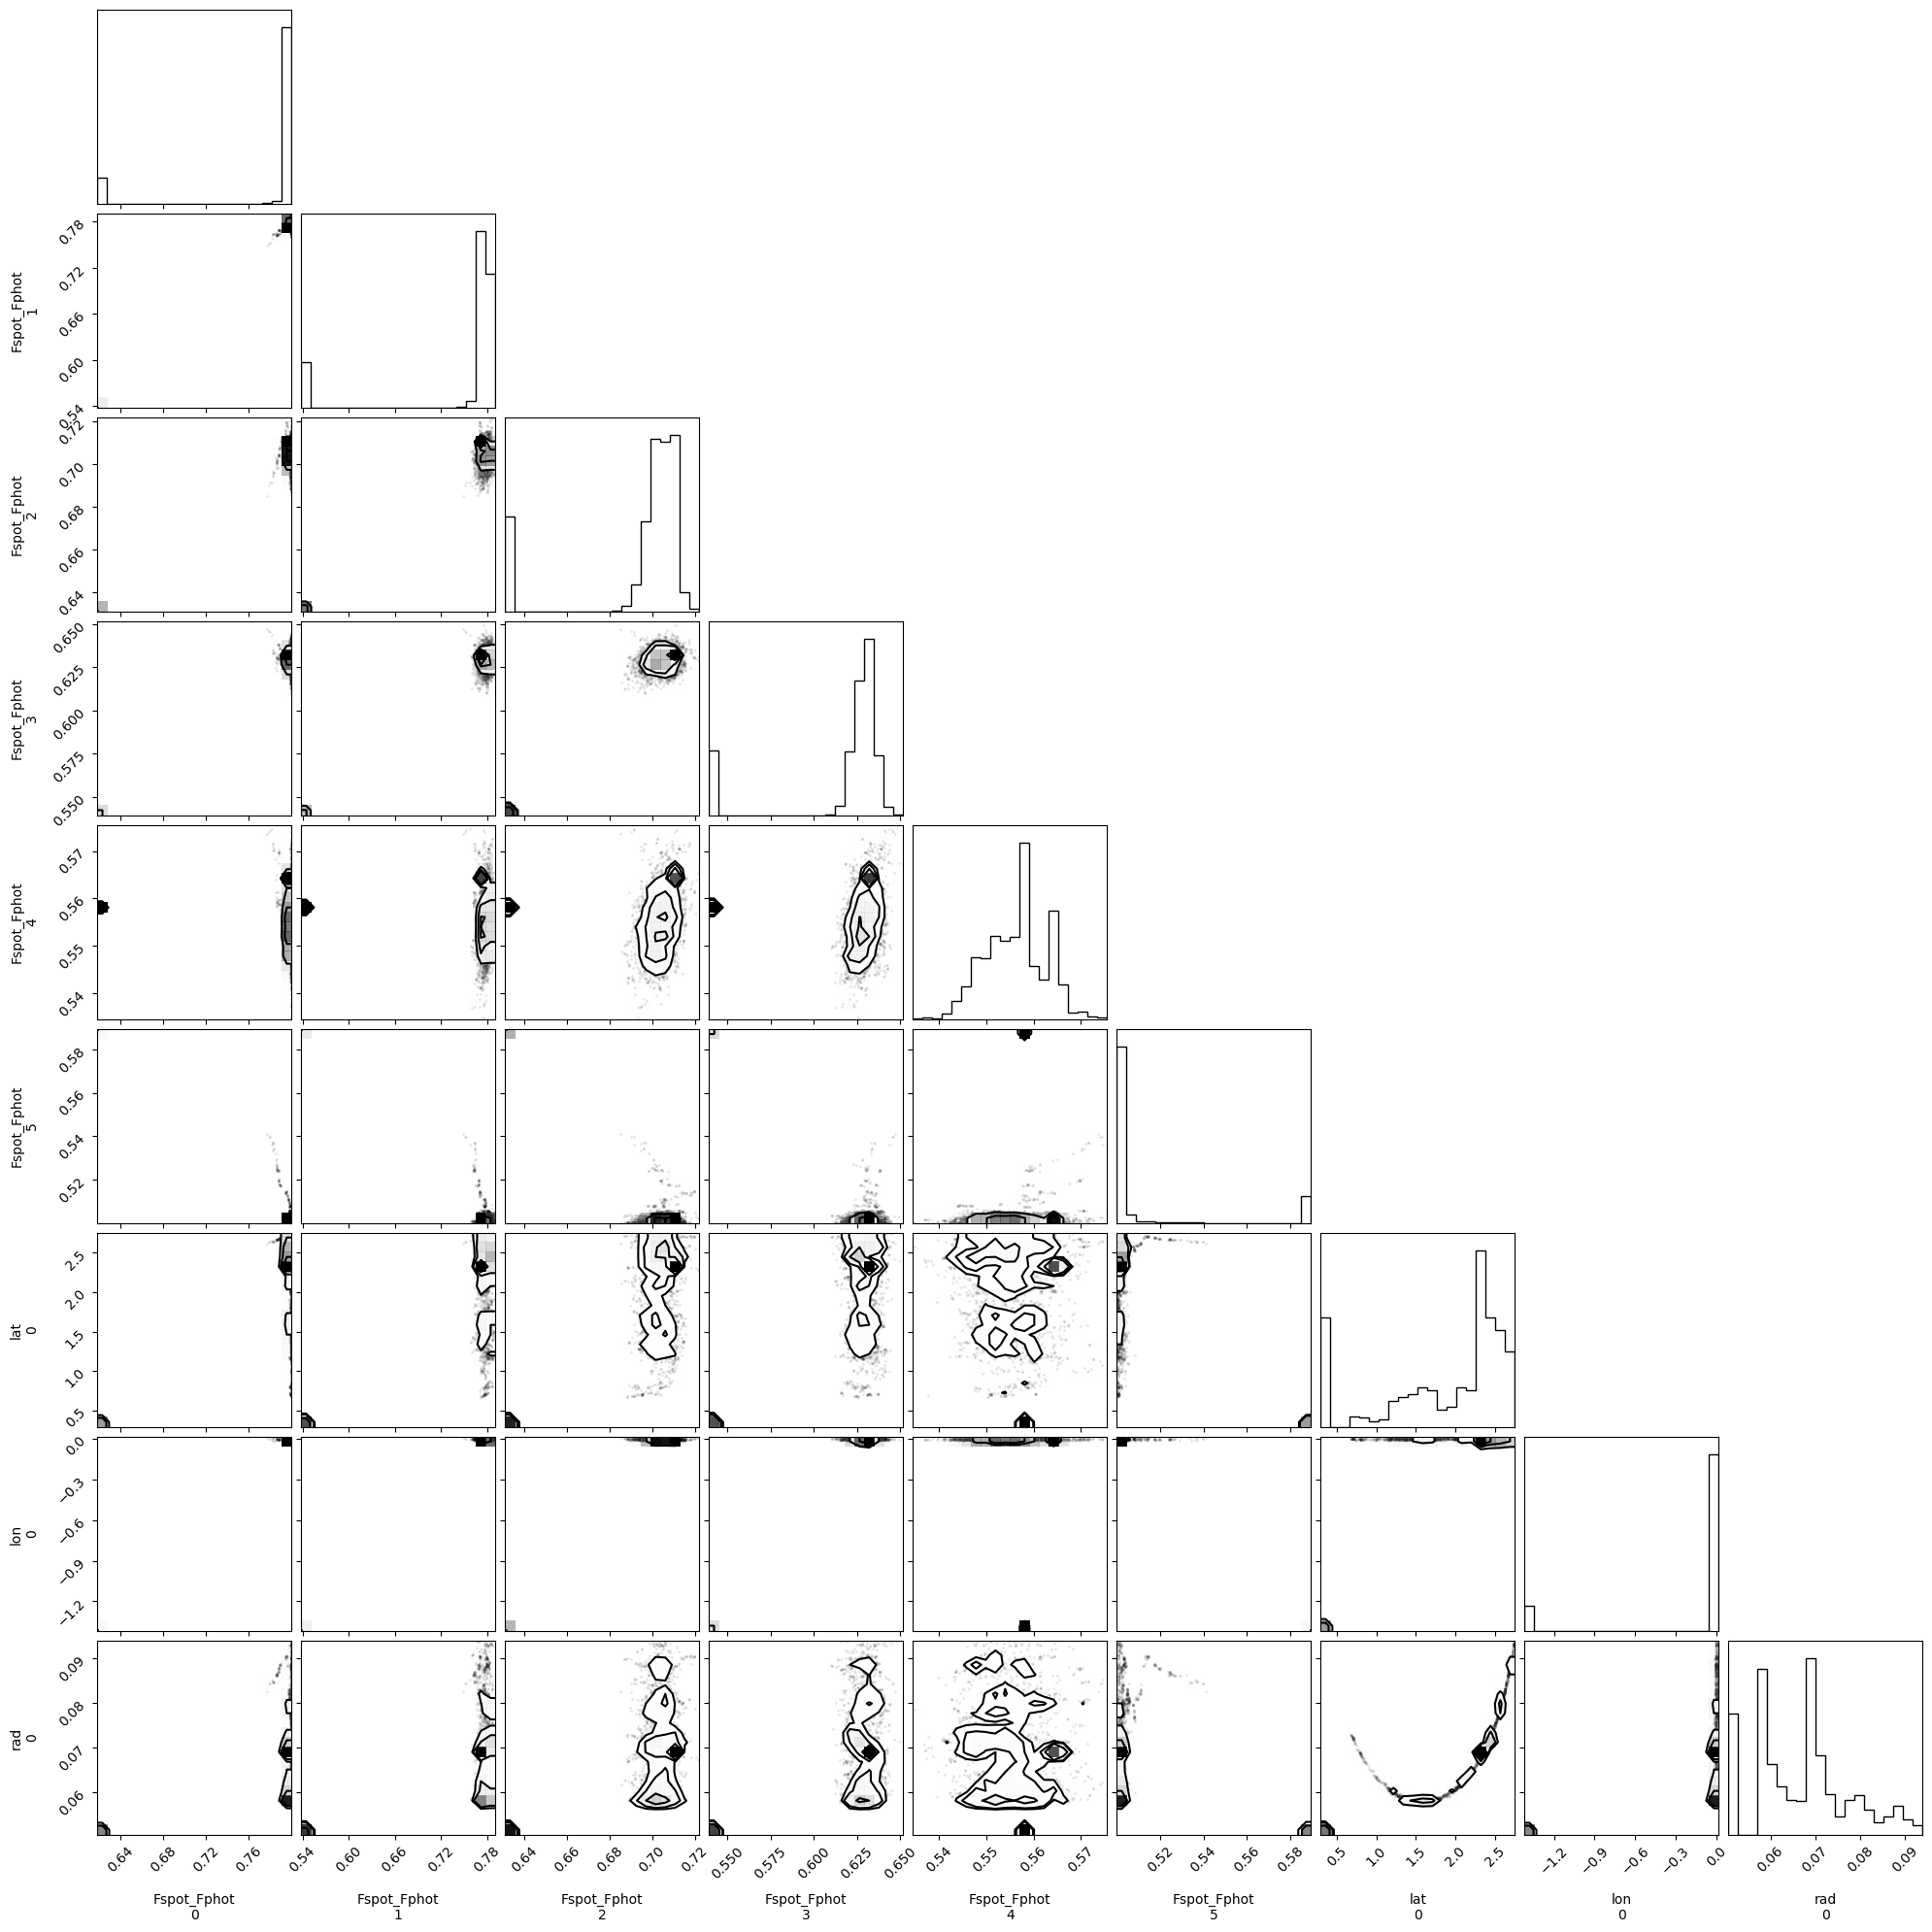

In [61]:
from corner import corner

corner(results, var_names=['~light_curve']);